# Imports and Setup

In [48]:
import argparse
import glob
import os
import random
import re
import pandas as pd
import numpy as np
import csv
import json
from IPython.core.display import HTML
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Spacy setup. Need to be done once.
!pip -q install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
## !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [2]:
import spacy
from spacy.lang.es.examples import sentences 
from spacy import displacy

print(spacy.__version__)
print(pd.__version__)

from nltk.parse import stanford, corenlp
NLP_ES = spacy.load("es_core_news_sm")
NLP_EN = spacy.load("en_core_web_sm")

3.7.2
1.4.2


In [3]:
from config import Config
args = Config()

In [4]:
# Helper methods
def get_neighbors(idx, id_to_head, head_to_ids, verbosity):
    as_list = []
    as_map = dict()

    if idx in id_to_head:
        upstream = id_to_head[idx]
        downstream = []
        if idx in head_to_ids:
            downstream = head_to_ids[idx]

        # Add to neighbors list
        as_list = [upstream, *downstream]
        # Add to the neighbors map
        as_map[f'{idx}'] = upstream
        for i in downstream:
            as_map[f'{i}'] = idx

    if verbosity > 1:
        print(f'idx:{idx}, as_list: {as_list}, as_map: {as_map}')

    return (as_list, as_map)

def dep_parsing_tree(nlp, text, correction_index, verbosity=0):
    doc = nlp(text)
    js_str = doc.to_json()
    id_to_head = dict() #dict([(token["id"], token["head"]) for token in js_str["tokens"]])
    head_to_ids = dict()
    for token in js_str["tokens"]:
        id = token["id"]
        head = token["head"]
        if token['pos'] != 'PUNCT':
            id_to_head[id] = head
            if head in head_to_ids:
                head_to_ids[head].append(id)
            else:
                head_to_ids[head] = [id]
    if verbosity > 0:
        print(f'id -> head: {id_to_head}')
        print(f'head -> ids: {head_to_ids}')            
        
    pred_parse_order = dict()
    for cor_idx in correction_index:
        # Get the head for the current correction index
        (as_list, as_map) = get_neighbors(cor_idx, id_to_head, head_to_ids, verbosity)
        for i in as_list:
            (_, sub_map) = get_neighbors(i, id_to_head, head_to_ids, verbosity)
            as_map.update(sub_map)          
        pred_parse_order.update(as_map)

#         if cor_idx in id_to_head:
#             first_order = id_to_head[cor_idx] # Do we need the downstream dependencies as well here?
#             tt = head_to_ids[cor_idx]
#             for t in tt:
#                 # get second order
#             second_order = head_to_ids[first_order]
#             pred_parse_order[f'{cor_idx}'] = first_order
#             for i in second_order:
#                 pred_parse_order[f'{i}'] = first_order

    if verbosity > 0:
        df_dep_tree = pd.DataFrame()
        df_dep_tree['text'] = [token.text for token in doc]
        df_dep_tree['lemma'] = [token.lemma_ for token in doc]
        df_dep_tree['is_punctuation'] = [token.is_punct for token in doc]
        df_dep_tree['is_space'] = [token.is_space for token in doc]
        df_dep_tree['shape'] = [token.shape_ for token in doc]
        df_dep_tree['part_of_speech'] = [token.pos_ for token in doc]
        df_dep_tree['pos_tag'] = [token.tag_ for token in doc]
        df_dep_tree['head'] = [token.head.text for token in doc] 
        df_dep_tree['dep'] = [token.dep_ for token in doc]
        html = displacy.render(doc, style="dep")
        HTML(html)
    return pred_parse_order

# Load Data and do Sanity Tests

## Sanity on Full Data

In [5]:
def load():
    converters = {'correction_index': pd.eval, 'source': pd.eval, 'target': pd.eval}
    # Converters not working
    df = pd.read_csv(args.PROCESSED_DATA_FOLDER + "/final_dataset.csv", index_col=None, header=0)
    return df

df = load()

/var/folders/g2/7p9zflv569l_wm_5vy9zvdbr0000gn/T/ipykernel_74022/958946777.py:4: DtypeWarning: Columns (6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(args.PROCESSED_DATA_FOLDER + "/final_dataset.csv", index_col=None, header=0)


In [6]:
# Check the columns
df.columns

Index(['Unnamed: 0', 'paragraph_id', 'sentence_id', 'course', 'essay_new',
       'annotated_sentence', 'full_error_tag', 'order_tag', 'error_tag',
       'correction', 'error', 'anno_error_cnt', 'error_type',
       'correction_index', 'source', 'target', 'check_target', 'check_source'],
      dtype='object')

In [7]:
# All rows should have an error_type
df[df.error_type.isnull()]

,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,correction,error,anno_error_cnt,error_type,correction_index,source,target,check_target,check_source


In [8]:
# Check for null values
df[df.notnull()].count()

Unnamed: 0            47083
paragraph_id          47083
sentence_id           47083
course                47083
essay_new             47083
annotated_sentence    47083
full_error_tag         5622
order_tag              5622
error_tag              5622
correction             5573
error                  5208
anno_error_cnt        47083
error_type            47083
correction_index      47083
source                47083
target                47083
check_target          47083
check_source          47083
dtype: int64

In [9]:
df.isna().sum()

Unnamed: 0                0
paragraph_id              0
sentence_id               0
course                    0
essay_new                 0
annotated_sentence        0
full_error_tag        41461
order_tag             41461
error_tag             41461
correction            41510
error                 41875
anno_error_cnt            0
error_type                0
correction_index          0
source                    0
target                    0
check_target              0
check_source              0
dtype: int64

In [10]:
# The srouce and target as loaded as string version of lists. Convert them to actual lists.
def convert_strings(row):
    row.source = eval(row.source)
    row.target = eval(row.target)
    
print(type(df.iloc[1].source))
df.apply(convert_strings, axis=1)
print(type(df.iloc[1].source))

<class 'str'>
<class 'str'>


In [11]:
# Add additional fields
df['evidence_index'] = np.empty((len(df), 0)).tolist()
df['predicted_parsing_order'] = ""
df['origin'] = 'A'

In [12]:
df.sample(n=5)

,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,correction,...,anno_error_cnt,error_type,correction_index,source,target,check_target,check_source,evidence_index,predicted_parsing_order,origin
15788,741,1222,6d453e1fa3849aa9b77d28a29e80d0df5905619d2a9046...,SPA 2,No fue suficiente para explorar todo el país!,No fue suficiente para explorar todo el país!,NaN,NaN,NaN,NaN,...,0,None,[],"['No', 'fue', 'suficiente', 'para', 'explorar'...","['No', 'fue', 'suficiente', 'para', 'explorar'...",0,0,[],,A
26984,248,358,1100e561e56a265e21a823dac7af90bc9e03f1ac269f40...,SPA 1,Su mejor amiga es Karlie Kloss.,Su mejor amiga es Karlie Kloss.,NaN,NaN,NaN,NaN,...,0,None,[],"['Su', 'mejor', 'amiga', 'es', 'Karlie', 'Klos...","['Su', 'mejor', 'amiga', 'es', 'Karlie', 'Klos...",0,0,[],,A
26858,241,351,8477d4c7645bd364fa3f921f70dc9cc5aba24629b4c6a1...,SPA 1,En 1978 el era el mas joven gobernado de Arksa...,En 1978 el era el mas joven gobernado de Arksa...,NaN,NaN,NaN,NaN,...,0,None,[],"['En', '1978', 'el', 'era', 'el', 'mas', 'jove...","['En', '1978', 'el', 'era', 'el', 'mas', 'jove...",0,0,[],,A
18226,857,1448,0fd1ee6646145eec4d69593662690c7a930486bb56ec20...,SPA 2,"Además, la capital de Corea, Seúl, es un lugar...","Además, la capital de Corea, Seúl, es un lugar...",NaN,NaN,NaN,NaN,...,0,None,[],"['Además', ',', 'la', 'capital', 'de', 'Corea'...","['Además', ',', 'la', 'capital', 'de', 'Corea'...",0,0,[],,A
37786,834,1394,bfb197d2b8fe99e0a1daaf4af08225ce97935bc95dd3e0...,SPA 1,"Mi ciudad favorita es Beijing, y es la capital...","Mi ciudad favorita es Beijing, y es la capital...",NaN,NaN,NaN,NaN,...,0,None,[],"['Mi', 'ciudad', 'favorita', 'es', 'Beijing', ...","['Mi', 'ciudad', 'favorita', 'es', 'Beijing', ...",0,0,[],,A


## Split Dataset into With Errors and Without Errors

In [13]:
# Split dataset into two dataframes one with errors and one without
df_no_errors = df.query('error_type == "None"').copy()
df_no_errors.reset_index(inplace=True)
df_no_errors.rename(columns={'index': "orig_index"}, inplace=True)
df_errors = df.query('error_type != "None"').copy()
df_errors['orig_error_type'] = df_errors['error_type']

df_errors.reset_index(inplace=True)
df_errors.rename(columns={'index': "orig_index"}, inplace=True)
df_errors


,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,...,anno_error_cnt,error_type,correction_index,source,target,check_target,check_source,evidence_index,predicted_parsing_order,origin
0,41461,0,1,5643cbe8e41322b9157848dae95bfc1d33e531b4d5e98d...,SPA 2,Las niñas de todo el país miran a Lauren y enc...,Las niñas de todo el país miran [a]{a}<aa:do:a...,[a]{a}<aa:do:an>,0.0,aa:do:an,...,1,aa:do,"[7, 33]","['Las', 'niñas', 'de', 'todo', 'el', 'país', '...","['Las', 'niñas', 'de', 'todo', 'el', 'país', '...",0,0,[],,A
1,41462,2,5,888d8bf63a6f44b4b925c61492c0240c21c55e8503c2d8...,SPA 3,Me gusta mucho Taylor Swift porque soy similar...,Me gusta mucho Taylor Swift porque soy similar...,[a]{a}<aa:do:an>,0.0,aa:do:an,...,1,aa:do,"[9, 22]","['Me', 'gusta', 'mucho', 'Taylor', 'Swift', 'p...","['Me', 'gusta', 'mucho', 'Taylor', 'Swift', 'p...",0,0,[],,A
2,41463,4,8,96d3244e9824d903da11192ce6b046b84c44b2da910561...,SPA 1,Ella enseña a muchas personas con sus conocimi...,Ella enseña [a]{a}<aa:do:an> muchas personas c...,[a]{a}<aa:do:an>,0.0,aa:do:an,...,1,aa:do,"[2, 12]","['Ella', 'enseña', 'a', 'muchas', 'personas', ...","['Ella', 'enseña', 'a', 'muchas', 'personas', ...",0,0,[],,A
3,41464,4,8,cd60f77dc5a4d52091b7ec9c8e47bd0c6f0c71a084908a...,SPA 1,Ella está feliz de ayudar a otras personas.,Ella está feliz de ayudar [a]{a}<aa:do:an> otr...,[a]{a}<aa:do:an>,0.0,aa:do:an,...,1,aa:do,"[5, 15]","['Ella', 'está', 'feliz', 'de', 'ayudar', 'a',...","['Ella', 'está', 'feliz', 'de', 'ayudar', 'a',...",0,0,[],,A
4,41465,4,8,e928d9f779186cc01fe17161ca830c8b6cd64d47e8b355...,SPA 1,Maya angelou escribe muchas historias para ayu...,Maya angelou escribe muchas historias para ayu...,[a]{a}<aa:do:an>,0.0,aa:do:an,...,1,aa:do,"[7, 19]","['Maya', 'angelou', 'escribe', 'muchas', 'hist...","['Maya', 'angelou', 'escribe', 'muchas', 'hist...",0,0,[],,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5617,47078,44,1492,f6f91450d7fd28e3df5266da689a9ee900195ee3d9a435...,SPA 3,Llevaria mi familia al Museo Nacional para mir...,Llevaria mi familia al Museo Nacional para mir...,[los]{las}<ga:fm:det:inan>,1.0,ga:fm:det:inan,...,4,ga:fm,"[9, 77]","['Llevaria', 'mi', 'familia', 'al', 'Museo', '...","['Llevaria', 'mi', 'familia', 'al', 'Museo', '...",0,0,[],,A
5618,47079,44,1492,f6f91450d7fd28e3df5266da689a9ee900195ee3d9a435...,SPA 3,Llevaria mi familia al Museo Nacional para mir...,Llevaria mi familia al Museo Nacional para mir...,[todo]{todas}<ga:na:fm:ps:det:inan>,2.0,ga:na:fm:ps:det:inan,...,4,ga:na:fm:ps,"[41, 109]","['Llevaria', 'mi', 'familia', 'al', 'Museo', '...","['Llevaria', 'mi', 'familia', 'al', 'Museo', '...",0,0,[],,A
5619,47080,44,1492,f6f91450d7fd28e3df5266da689a9ee900195ee3d9a435...,SPA 3,Llevaria mi familia al Museo Nacional para mir...,Llevaria mi familia al Museo Nacional para mir...,[los]{las}<ga:fm:det:inan>,3.0,ga:fm:det:inan,...,4,ga:fm,"[42, 110]","['Llevaria', 'mi', 'familia', 'al', 'Museo', '...","['Llevaria', 'mi', 'familia', 'al', 'Museo', '...",0,0,[],,A
5620,47081,47,1623,d136aa5a6cdd9ba0c56a12b3e4b24b37f0f8293d013291...,SPA 2,"Entonces será certificado como “perfecto"".",Entonces será [certificado]{certificadas}<ga:f...,[certificado]{certificadas}<ga:fm:adj:inan>,0.0,ga:fm:adj:inan,...,2,ga:fm,"[2, 11]","['Entonces', 'será', 'certificado', 'como', '""...","['Entonces', 'será', 'certificadas', 'como', '...",0,0,[],,A


In [14]:
df_errors.to_csv(args.PROCESSED_DATA_FOLDER + "/final_with_errors.csv", index=False)

In [15]:
df_errors.index[(df_errors.essay_new == 'Ella está feliz de ayudar a otras personas.')]

Int64Index([3], dtype='int64')

In [16]:
df_errors[df_errors.notnull()].count()

orig_index                 5622
Unnamed: 0                 5622
paragraph_id               5622
sentence_id                5622
course                     5622
essay_new                  5622
annotated_sentence         5622
full_error_tag             5622
order_tag                  5622
error_tag                  5622
correction                 5573
error                      5208
anno_error_cnt             5622
error_type                 5622
correction_index           5622
source                     5622
target                     5622
check_target               5622
check_source               5622
evidence_index             5622
predicted_parsing_order    5622
origin                     5622
dtype: int64

In [17]:
df_no_errors[df_no_errors.notnull()].count()

orig_index                 41461
Unnamed: 0                 41461
paragraph_id               41461
sentence_id                41461
course                     41461
essay_new                  41461
annotated_sentence         41461
full_error_tag                 0
order_tag                      0
error_tag                      0
correction                     0
error                          0
anno_error_cnt             41461
error_type                 41461
correction_index           41461
source                     41461
target                     41461
check_target               41461
check_source               41461
evidence_index             41461
predicted_parsing_order    41461
origin                     41461
dtype: int64

In [18]:
df_errors.full_error_tag.unique()

array(['[a]{a}<aa:do:an>', '[]{a}<az:do:an>', '[a]{}<za:do:inan>', ...,
       '[fresco]{frescos}<na:ps:adj:inan>',
       '[encurtido]{encurtidos}<na:ps:adj:inan>',
       '[certificado]{certificadas}<ga:fm:adj:inan>'], dtype=object)

In [19]:
df_errors.error_type.unique()

array(['aa:do', 'az:do', 'za:do', 'aa:io', 'az:io', 'na:ps', 'ga:fm',
       'ga:mf:det:aty', 'ga:mf', 'ig:f', 'na:sp', 'in:s', 'ga:na:fm:ps',
       'ga:fm:det:aty', 'ga:ps', 'ig:e', 'ig:m', 'ga:na:mf:ps',
       'ga:mf:noun:aty', 'ga:mf:adj:aty', 'ga:na:fm:sp', 'ga:na:mf:sp',
       'in:p', 'ga:fm:adj:aty', 'ga:fm:noun:aty', 'ig:in:f:s',
       'ga:fm:gat:noun', 'in:p:gat:noun', 'na:sp:gat:noun',
       'ga:mf:pron:aty', 'in:s:gat:noun', 'ga'], dtype=object)

In [37]:
# Reduce the number of error classes to 4 - ga, na, ga-na and az.
error_map = {
'aa:do': 'az',
'az:do': 'az',
'za:do': 'az',
'aa:io': 'az',
'az:io': 'az',
'na:ps': 'na',
'ga:fm': 'ga',
'ga:mf:det:aty': 'ga',
'ga:mf': 'ga',
'ig:f': 'na',
'na:sp': 'na',
'in:s': 'na',
'ga:na:fm:ps': 'ga-na',
'ga:fm:det:aty': 'ga',
'ga:ps': 'ga',
'ig:e': 'na',
'ig:m': 'na',
'ga:na:mf:ps': 'ga-na',
'ga:mf:noun:aty': 'ga',
'ga:mf:adj:aty': 'ga',
'ga:na:fm:sp': 'ga-na',
'ga:na:mf:sp': 'ga-na',
'in:p': 'na',
'ga:fm:adj:aty': 'ga',
'ga:fm:noun:aty': 'ga',
'ig:in:f:s': 'na',
'ga:fm:gat:noun': 'ga',
'in:p:gat:noun': 'na',
'na:sp:gat:noun': 'na',
'ga:mf:pron:aty': 'ga',
'in:s:gat:noun': 'na',
'ga': 'ga'}

df_errors['error_type'] = df_errors.apply(lambda row: error_map[row.orig_error_type], axis=1)

In [39]:
df_errors.error_type.value_counts()

ga       2833
na       1617
az        881
ga-na     291
Name: error_type, dtype: int64

## Sanity Check Lines with Errors

In [40]:
def compute_status(row):
    num_len_mismatch = 0
    num_extra_corrections = 0
    source = eval(row.source)
    target = eval(row.target)
    correction_index = set(eval(row.correction_index))
    row_status = 'GOOD'
    if len(source) != len(target):
        num_len_mismatch = num_len_mismatch + 1
        row_status = 'LEN_MISMATCH'
    else:
        mismatches = map(lambda x: x[0] == x[1], zip(source, target))
        for (i, flag) in enumerate(mismatches):
            if not flag and i not in correction_index:
                # print('Extra corrections')
                num_extra_corrections = num_extra_corrections + 1
                row_status = 'EXTRA_CORRECTIONS'
                break
    # row['status'] = row_status
    return row_status
    # print(f'Found {num_len_mismatch} entries and {num_extra_corrections} entries with extra corrections')

def check_errors():
    df_tt = df_errors[['orig_index', 'sentence_id', 'essay_new', 'source', 'target', 'correction_index']].copy(deep=True)
    df_tt['status'] = df_tt.apply(compute_status, axis=1)
    df_tt['has_annotation'] = df_tt.apply(lambda row: '<' in row.source or '<' in row.target, axis=1)
    return df_tt
    
df_error_status = check_errors()

In [41]:
print('Should have just GOOD rows')
print(df_error_status.status.value_counts())

print()
print('Should not have annotations')
print(df_error_status.has_annotation.value_counts())

with pd.option_context('display.max_colwidth', None):
    display(df_error_status[df_error_status['status'] == 'EXTRA_CORRECTIONS'].sample(2))
    print("----------------------")
    display(df_error_status[df_error_status.has_annotation == True].sample(2))

Should have just GOOD rows
GOOD                 3364
EXTRA_CORRECTIONS    2258
Name: status, dtype: int64

Should not have annotations
False    5188
True      434
Name: has_annotation, dtype: int64


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation
5489,46950,40354ac2049016ed042beca9bf09a02534a863475c5ca1ce8dce030ece28215c,Hawaii es un magical lugar y es perfecta para vaccacines todos ano durante.,"['Hawaii', 'es', 'un', 'magical', 'lugar', 'y', 'es', 'perfecto', 'para', 'vaccacines', 'todos', 'ano', 'durante', '.']","['Hawaii', 'es', 'un', 'magical', 'lugar', 'y', 'es', 'perfecta', 'para', 'vaccacines', 'todos', 'años', 'durante', '.']","[11, 26]",EXTRA_CORRECTIONS,False
4636,46097,f5502334cc91a3b1310897944c13e8506c3f3e2bbe86e54503e2e7711787eed7,El vacaciones a Hawaii estaría perfecto.,"['las', 'vacaciones', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'a', 'Hawaii', 'estaría', 'perfecto', '.']","['El', 'vacaciones', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'a', 'Hawaii', 'estaría', 'perfectas', '.']","[12, 27]",EXTRA_CORRECTIONS,True


----------------------


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation
4625,46086,1ead1e0df5653bdc44582d7020434620af1d05dda0d3f3f0661c8f87ccb907e0,Yo escucho que Madrid es un ciudad muy bonito y me gusta viajar en Madrid con sus museos y parques.,"['Yo', 'escucho', 'que', 'Madrid', 'es', 'un', 'ciudad', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'muy', 'bonito', 'y', 'me', 'gusta', 'viajar', 'en', 'Madrid', 'con', 'sus', 'museos', 'y', 'parques', '.']","['Yo', 'escucho', 'que', 'Madrid', 'es', 'una', 'ciudad', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'muy', 'bonita', 'y', 'me', 'gusta', 'viajar', 'en', 'Madrid', 'con', 'sus', 'museos', 'y', 'parques', '.']","[5, 34]",EXTRA_CORRECTIONS,True
4942,46403,85aa15e953b0e1419745efeb66ba222ba5747de3f8c561d0226822c6f6ecffd6,"En general, me gustaría que mis vacaciones para ser divertido y emocionante pero tranquilo.","['En', 'general', ',', 'me', 'gustaría', 'que', 'mis', 'vacaciones', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'para', 'ser', 'divertidas', 'y', 'emocionante', 'pero', 'tranquilo', '.']","['En', 'general', ',', 'me', 'gustaría', 'que', 'mis', 'vacaciones', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'para', 'ser', 'divertido', 'y', 'emociantes', 'pero', 'tranquilas', '.']","[19, 43]",EXTRA_CORRECTIONS,True


# Explore EXPECT dataset

In [25]:
def load_expect_data(num_lines=None):
    expect_train_file = f"{args.EXPLAINABLE_GEC_DATA_FOLDER}/train.json"
    with open(expect_train_file, "r") as file1:
        count = 0
        rows = file1.readlines()
        df = pd.DataFrame([eval(row) for row in rows])
        df['source_org'] = df.source.map(lambda v: ' '.join(v).replace(" .", "."))        
        df['target_org'] = df.target.map(lambda v: ' '.join(v).replace(" .", "."))
        return df

df_expect = load_expect_data()


In [26]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.sample(5))

,target,source,evidence_index,correction_index,error_type,predicted_parsing_order,origin,source_org,target_org
8524,"[First, of, all, ,, transport, is, the, most, significant, carbon, dioxide, [NONE], emitter, .]","[First, of, all, ,, transport, is, the, most, significant, carbon, dioxide, 's, emitter, .]","[9, 10, 12, 24, 25, 27]","[11, 26]",POS Confusion,"{'11': 1, '26': 1}",B,"First of all , transport is the most significant carbon dioxide 's emitter.","First of all , transport is the most significant carbon dioxide [NONE] emitter."
5919,"[To, put, it, simply, ,, the, new, generation, has, decided, to, take, their, driving, licence, and, I, have, seen, this, around, me, ,, with, my, colleagues, ,, my, friends, ,, my, family, .]","[To, put, it, simply, ,, the, new, generation, has, decided, to, take, their, driving, licence, and, I, have, seen, this, around, me, ,, [NONE], my, colleagues, ,, my, friends, ,, my, family, .]","[24, 25, 58, 59]","[23, 57]",Preposition,"{'18': 3, '22': 2, '23': 1, '25': 3, '26': 2, '28': 3, '29': 3, '52': 3, '56': 2, '57': 1, '59': 3, '60': 2, '62': 3, '63': 3}",A,"To put it simply , the new generation has decided to take their driving licence and I have seen this around me , [NONE] my colleagues , my friends , my family.","To put it simply , the new generation has decided to take their driving licence and I have seen this around me , with my colleagues , my friends , my family."
5849,"[Basketball, is, recognized, by, people, all, over, the, world, .]","[Basketball, is, recognize, by, people, all, over, the, world, .]","[0, 1, 3, 4, 11, 12, 14, 15]","[2, 13]",Participle,"{'0': 2, '1': 2, '2': 1, '3': 2, '4': 3, '9': 2, '11': 2, '12': 2, '13': 1, '14': 2, '15': 3, '20': 2}",A,Basketball is recognize by people all over the world.,Basketball is recognized by people all over the world.
9125,"[Anyway, ,, I, still, love, him, and, still, have, the, hope, that, this, is, just, a, temporary, period, in, our, life, and, he, will, be, back, to, the, man, I, loved, once, ,, especially, since, we, have, the, most, amazing, reason, to, live, for, ;, it, 's, our, beautiful, son, ,, our, angel, and, the, amazing, love, of, our, lives, .]","[Anyway, ,, I, still, love, him, and, still, have, the, hope, that, this, is, just, a, temporary, period, in, our, life, and, he, will, be, back, to, the, man, I, loved, once, ,, especially, that, we, have, the, most, amazing, reason, to, live, for, ;, it, 's, our, beautiful, son, ,, our, angel, and, the, amazing, love, of, our, lives, .]",[],"[34, 96]",Others,"{'24': 3, '33': 2, '34': 1, '86': 3, '95': 2, '96': 1}",B,"Anyway , I still love him and still have the hope that this is just a temporary period in our life and he will be back to the man I loved once , especially that we have the most amazing reason to live for ; it 's our beautiful son , our angel and the amazing love of our lives.","Anyway , I still love him and still have the hope that this is just a temporary period in our life and he will be back to the man I loved once , especially since we have the most amazing reason to live for ; it 's our beautiful son , our angel and the amazing love of our lives."
7122,"[If, you, want, to, play, this, sport, ,, you, have, to, make, a, really, big, effort, and, try, to, practise, as, much, as, possible, .]","[If, you, want, to, play, this, sport, ,, I, have, to, make, a, really, big, effort, and, try, to, practise, as, much, as, possible, .]",[],"[8, 34]",Possessive,"{'2': 2, '8': 1, '9': 3, '28': 2, '34': 1, '35': 3}",B,"If you want to play this sport , I have to make a really big effort and try to practise as much as possible.","If you want to play this sport , you have to make a really big effort and try to practise as much as possible."


In [27]:
df_expect.isna().sum()

target                     0
source                     0
evidence_index             0
correction_index           0
error_type                 0
predicted_parsing_order    0
origin                     0
source_org                 0
target_org                 0
dtype: int64

## Dependency parsing tree on EXPECT

In [28]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.iloc[11872])

target                                 [The, periodic, movement, of, the, minute, hand, compared, to, the, smooth, path, of, the, second, hand, .]
source                                     [The, periodic, move, of, the, minute, hand, compared, to, the, smooth, path, of, the, second, hand, .]
evidence_index                                                                                                                      [0, 1, 18, 19]
correction_index                                                                                                                           [2, 20]
error_type                                                                                                                           POS Confusion
predicted_parsing_order    {'0': 2, '1': 2, '2': 1, '3': 2, '5': 3, '6': 3, '7': 2, '18': 2, '19': 2, '20': 1, '21': 2, '23': 3, '24': 3, '25': 2}
origin                                                                                                                

In [29]:
def show_one_EXPECT(nlp, row_idx):
    row = df_expect.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.target_org, row.correction_index, verbosity=1)
    print()
    print(f'Orig: {row.source_org}')
    print(f'Corr: {row.target_org}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print(f'Corr: {row.target_org}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print(f'Original pred_parse_order: {row.predicted_parsing_order}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

# show_one_EXPECT(11872)
show_one_EXPECT(NLP_EN, 1314)
    

id -> head: {0: 1, 1: 3, 2: 3, 3: 3, 4: 5, 5: 3}
head -> ids: {1: [0], 3: [1, 2, 3, 5], 5: [4]}



Orig: Castle also has a courtyard.
Corr: The castle also has a courtyard.
Concatenated: ['Castle', 'also', 'has', 'a', 'courtyard', '.', 'SEP', 'The', 'castle', 'also', 'has', 'a', 'courtyard', '.']
Corr: The castle also has a courtyard.

Correction index: [0, 1, 8]

Corrected offset: 8
Original pred_parse_order: {'0': 1, '1': 1, '3': 2, '8': 1, '10': 2}

computed pred_parse_order: {'0': 1, '1': 3, '3': 3, '2': 3, '5': 3}


In [30]:
print("Evidence words are important for GEC")
print(f'computed pred_parse_order: {dep_parsing_tree(spacy.load("en_core_web_sm"), "Evidence words are important for GEC", [2])}')


Evidence words are important for GEC
computed pred_parse_order: {'2': 2, '1': 2, '3': 2, '4': 2, '0': 1, '5': 4}


In [31]:
show_one_EXPECT(NLP_EN, 1314)

id -> head: {0: 1, 1: 3, 2: 3, 3: 3, 4: 5, 5: 3}
head -> ids: {1: [0], 3: [1, 2, 3, 5], 5: [4]}



Orig: Castle also has a courtyard.
Corr: The castle also has a courtyard.
Concatenated: ['Castle', 'also', 'has', 'a', 'courtyard', '.', 'SEP', 'The', 'castle', 'also', 'has', 'a', 'courtyard', '.']
Corr: The castle also has a courtyard.

Correction index: [0, 1, 8]

Corrected offset: 8
Original pred_parse_order: {'0': 1, '1': 1, '3': 2, '8': 1, '10': 2}

computed pred_parse_order: {'0': 1, '1': 3, '3': 3, '2': 3, '5': 3}


In [32]:
show_one_EXPECT(NLP_EN, 11872)

id -> head: {0: 2, 1: 2, 2: 7, 3: 2, 4: 6, 5: 6, 6: 3, 7: 7, 8: 7, 9: 11, 10: 11, 11: 8, 12: 11, 13: 15, 14: 15, 15: 12}
head -> ids: {2: [0, 1, 3], 7: [2, 7, 8], 6: [4, 5], 3: [6], 11: [9, 10, 12], 8: [11], 15: [13, 14], 12: [15]}



Orig: The periodic move of the minute hand compared to the smooth path of the second hand.
Corr: The periodic movement of the minute hand compared to the smooth path of the second hand.
Concatenated: ['The', 'periodic', 'move', 'of', 'the', 'minute', 'hand', 'compared', 'to', 'the', 'smooth', 'path', 'of', 'the', 'second', 'hand', '.', 'SEP', 'The', 'periodic', 'movement', 'of', 'the', 'minute', 'hand', 'compared', 'to', 'the', 'smooth', 'path', 'of', 'the', 'second', 'hand', '.']
Corr: The periodic movement of the minute hand compared to the smooth path of the second hand.

Correction index: [2, 20]

Corrected offset: 18
Original pred_parse_order: {'0': 2, '1': 2, '2': 1, '3': 2, '5': 3, '6': 3, '7': 2, '18': 2, '19': 2, '20': 1, '21': 2, '23': 3, '24': 3, '25': 2}

computed pred_parse_order: {'2': 7, '0': 2, '1': 2, '3': 2, '7': 7, '8': 7, '6': 3}


In [33]:
show_one_EXPECT(NLP_EN, 1289)

id -> head: {0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 6, 6: 4}
head -> ids: {1: [0], 2: [1, 2, 3, 4], 6: [5], 4: [6]}



Orig: The waiter come and took the order.
Corr: The waiter came and took the order.
Concatenated: ['The', 'waiter', 'come', 'and', 'took', 'the', 'order', '.', 'SEP', 'The', 'waiter', 'came', 'and', 'took', 'the', 'order', '.']
Corr: The waiter came and took the order.

Correction index: [2, 11]

Corrected offset: 9
Original pred_parse_order: {'0': 3, '1': 2, '2': 1, '3': 2, '4': 2, '6': 3, '7': 2, '9': 3, '10': 2, '11': 1, '12': 2, '13': 2, '15': 3, '16': 2}

computed pred_parse_order: {'2': 2, '1': 2, '3': 2, '4': 2, '0': 1, '6': 4}


# Process COWS-L2H Data

## Add Dependency Parse Tree (Spacy)

In [42]:
def COWSL2H_parsing_order(nlp, df, row_idx):
    row = df.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.essay_new, eval(row.correction_index), verbosity=2)
    print()
    print(f'Orig: {" ".join(eval(row.source))}')
    print(f'Corr: {row.essay_new}')
    print(f'row.source: {row.source}')
    print(f'row.target: {row.target}')
    concacted = [*eval(row.source), 'SEP', *eval(row.target)]
    print(f'Concatenated: {concacted}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(eval(row.target)) + 1}')
    print(f'Original pred_parse_order: {row.predicted_parsing_order}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

In [43]:
%%time
def add_dependencies(df):
    def add_parsing_order(row):
        return dep_parsing_tree(NLP_ES, row.essay_new, eval(row.correction_index), verbosity=0)        
        
    df['predicted_parsing_order'] = df.apply(add_parsing_order, axis=1)
    df['parsing_order_len'] = df_errors.apply(lambda row: len(row.predicted_parsing_order), axis=1)

add_dependencies(df_errors)

CPU times: user 22.1 s, sys: 56.8 ms, total: 22.2 s
Wall time: 22.2 s


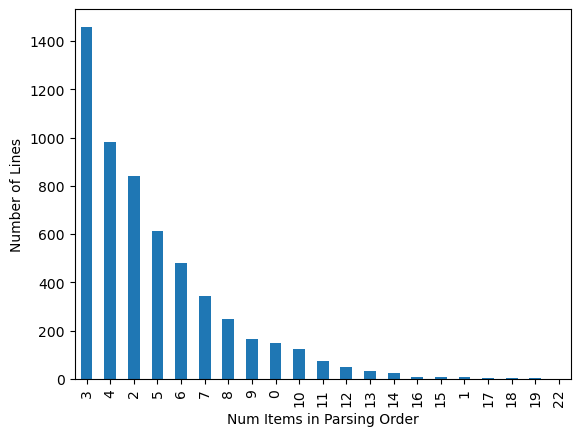

In [52]:
df_errors.parsing_order_len.value_counts().transpose().plot.bar()
plt.xlabel("Num Items in Parsing Order")
plt.ylabel("Number of Lines")
plt.show()

In [53]:
# Explore the rows with empty parsing order
with pd.option_context('display.max_colwidth', None):
    display(df_errors[df_errors.parsing_order_len == 0].sample(10))

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,...,correction_index,source,target,check_target,check_source,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len
3620,45081,87,141,f89568f87e527471b16bf2872c87e6b8fcdfd38648936107a3181552eb74fcf0,SPA 1,El pelicula Top Gun es mucho famoso.,[El]{la}<ga:fm:det:inan> pelicula<gat:noun:inan> Top Gun es mucho [famoso]{famosa}<ga:fm:adj:inan>.,[famoso]{famosa}<ga:fm:adj:inan>,1.0,ga:fm:adj:inan,...,"[13, 29]","['la', 'pelicula', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'Top', 'Gun', 'es', 'mucho', 'famoso', '.']","['El', 'pelicula', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'Top', 'Gun', 'es', 'mucho', 'famosa', '.']",0,0,[],{},A,ga:fm,0
3418,44879,821,1363,7fb0c6b9e1bb965cf21ca24cd62110527336fa456aff774bd15c44f4de030811,SPA 2,"Una hermosa vista ayuda, pero me encantaría tener a mis sobrinos y sobrinas allí, mis dos hermanos, mi hermana y mis padres.","Una hermosa vista ayuda, pero me encantaría tener [a]{a}<aa:do:an> mis sobrinos y []{a}<az:do:an> sobrinas allí, []{a}<az:do:an> mis dos hermanos, []{a}<az:do:an> mi hermana y []{a}<az:do:an> mis padres.",[]{a}<az:do:an>,4.0,az:do:an,...,"[26, 57]","['Una', 'hermosa', 'vista', 'ayuda', ',', 'pero', 'me', 'encantaría', 'tener', 'a', 'mis', 'sobrinos', 'y', 'a', 'sobrinas', 'allí', ',', 'a', 'mis', 'dos', 'hermanos', ',', 'a', 'mi', 'hermana', 'y', '[NONE]', 'mis', 'padres', '.']","['Una', 'hermosa', 'vista', 'ayuda', ',', 'pero', 'me', 'encantaría', 'tener', 'a', 'mis', 'sobrinos', 'y', '[NONE]', 'sobrinas', 'allí', ',', '[NONE]', 'mis', 'dos', 'hermanos', ',', '[NONE]', 'mi', 'hermana', 'y', 'a', 'mis', 'padres', '.']",0,0,[],{},A,az:do,0
4065,45526,330,499,597678aa7de939b12420d8af4cfdcba9d2dd52c844a49f2576ddc9a8243b1ba4,SPA 2,Mi persona famoso favorito es Beyonce.,Mi persona<gat:noun:inan> [famoso]{famosa}<ga:fm:adj:an> [favorito]{favorita}<ga:fm:adj:an> es Beyonce.,[famoso]{famosa}<ga:fm:adj:an>,0.0,ga:fm:adj:an,...,"[9, 24]","['Mi', 'persona', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'famoso', 'favorito', 'es', 'Beyonce', '.']","['Mi', 'persona', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'famosa', 'favorita', 'es', 'Beyonce', '.']",0,0,[],{},A,ga:fm,0
3608,45069,79,127,13b66129bae7a59227f2e2e615fd052c3172565200c68fe18e5ac4559aeba909,SPA 2,Este pelicula es muy agresivo y tiene muchas sangres.,[Este]{esta}<ga:fm:det:inan> pelicula<gat:noun:inan> es muy [agresivo]{agresiva}<ga:fm:adj:inan> y tiene [muchas]{mucha}<na:sp:det:inan> [sangres]{sangre}<na:sp:noun:inan>.,[sangres]{sangre}<na:sp:noun:inan>,3.0,na:sp:noun:inan,...,"[15, 33]","['esta', 'pelicula', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'es', 'muy', 'agresiva', 'y', 'tiene', 'mucha', 'sangres', '.']","['Este', 'pelicula', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'es', 'muy', 'agresivo', 'y', 'tiene', 'muchas', 'sangre', '.']",0,0,[],{},A,na:sp,0
3751,45212,186,277,fe211456f98cd6ae5cb93b88a1c8b93d772e21e2372ed577dd5eff87ab7ed35f,SPA 2,Son ambos Portugués perros de agua y son muy bonitas y activas.,Son ambos [Portugués]{portugueses}<na:ps:adj:an> perros<gat:noun:an> de agua y son muy [bonitas]{bonitos}<ga:mf:adj:an> y [activas]{activos}<ga:mf:adj:an>.,[activas]{activos}<ga:mf:adj:an>,2.0,ga:mf:adj:an,...,"[18, 39]","['Son', 'ambos', 'portugueses', 'perros', '<', 'gat', ':', 'noun', ':', 'an', '>', 'de', 'agua', 'y', 'son', 'muy', 'bonitos', 'y', 'activas', '.']","['Son', 'ambos', 'Portugués', 'perros', '<', 'gat', ':', 'noun', ':', 'an', '>', 'de', 'agua', 'y', 'son', 'muy', 'bonitas', 'y', 'activos', '.']",0,0,[],{},A,ga:mf,0
4360,45821,480,841,728c7152ab99c1b5fd38855ae2ed34b3ce256b78ccf525010945b41b0fefe0d6,SPA 3,La primera album es mi favorita.,[La]{el}<ga:mf:det:inan> [primera]{primer}<ga:mf:det:inan> álbum<gat:noun:inan> es mi [favorita]{favorito}<ga:mf:adj:inan>.,[favorita]{favorito}<ga:mf:adj:inan>,2.0,ga:mf:adj:inan,...,"[12, 27]","['el', 'primer', 'álbum', '<', 'gat'

In [54]:
df_errors[df_errors.essay_new == 'El Alpes Suzios es un cordillera magnifico.']

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,...,correction_index,source,target,check_target,check_source,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len
4831,46292,693,1166,15c6d9ec7a41a5c262c873d45d22bbc1346aa709dd3a80...,SPA 2,El Alpes Suzios es un cordillera magnifico.,[El]{los}<na:ps:det:inan> Alpes Suzios es [un]...,[El]{los}<na:ps:det:inan>,0.0,na:ps:det:inan,...,"[0, 16]","['El', 'Alpes', 'Suzios', 'es', 'un', 'cordill...","['los', 'Alpes', 'Suzios', 'es', 'una', 'cordi...",0,0,[],"{'0': 1, '1': 5, '2': 1}",A,na:ps,3
4832,46293,693,1166,15c6d9ec7a41a5c262c873d45d22bbc1346aa709dd3a80...,SPA 2,El Alpes Suzios es un cordillera magnifico.,[El]{los}<na:ps:det:inan> Alpes Suzios es [un]...,[un]{una}<ga:fm:det:inan>,1.0,ga:fm:det:inan,...,"[4, 20]","['los', 'Alpes', 'Suzios', 'es', 'un', 'cordil...","['El', 'Alpes', 'Suzios', 'es', 'una', 'cordil...",0,0,[],"{'4': 5, '5': 5, '1': 5, '3': 5, '6': 5}",A,ga:fm,5
4833,46294,693,1166,15c6d9ec7a41a5c262c873d45d22bbc1346aa709dd3a80...,SPA 2,El Alpes Suzios es un cordillera magnifico.,[El]{los}<na:ps:det:inan> Alpes Suzios es [un]...,[magnifico]{magnífica}<ga:fm:adj:inan>,2.0,ga:fm:adj:inan,...,"[13, 29]","['los', 'Alpes', 'Suzios', 'es', 'una', 'cordi...","['El', 'Alpes', 'Suzios', 'es', 'un', 'cordill...",0,0,[],{},A,ga:fm,0


In [55]:
ids_to_check = [4833, 5621]
# print(df_errors.iloc[id_to_check])
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].essay_new))
for idx in ids_to_check:
    COWSL2H_parsing_order(NLP_ES, df_errors, idx)
# parsing_order = dep_parsing_tree(NLP_ES, df_errors.iloc[id_to_check].essay_new, eval(df_errors.iloc[id_to_check].correction_index), verbosity=2)


id -> head: {0: 1, 1: 5, 2: 1, 3: 5, 4: 5, 5: 5, 6: 5}
head -> ids: {1: [0, 2], 5: [1, 3, 4, 5, 6]}
idx:13, as_list: [], as_map: {}
idx:29, as_list: [], as_map: {}



Orig: los Alpes Suzios es una cordillera < gat : noun : inan > magnifico .
Corr: El Alpes Suzios es un cordillera magnifico.
row.source: ['los', 'Alpes', 'Suzios', 'es', 'una', 'cordillera', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'magnifico', '.']
row.target: ['El', 'Alpes', 'Suzios', 'es', 'un', 'cordillera', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'magnífica', '.']
Concatenated: ['los', 'Alpes', 'Suzios', 'es', 'una', 'cordillera', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'magnifico', '.', 'SEP', 'El', 'Alpes', 'Suzios', 'es', 'un', 'cordillera', '<', 'gat', ':', 'noun', ':', 'inan', '>', 'magnífica', '.']

Correction index: [13, 29]

Corrected offset: 16
Original pred_parse_order: {}

computed pred_parse_order: {}
id -> head: {0: 2, 1: 2, 2: 2, 3: 4, 4: 2, 5: 4}
head -> ids: {2: [0, 1, 2, 4], 4: [3, 5]}
idx:5, as_list: [4], as_map: {'5': 4}
idx:4, as_list: [2, 3, 5], as_map: {'4': 2, '3': 4, '5': 4}
idx:14, as_list: [], as_map: {}



Orig: Entonces será certificadas como " perfecto " .
Corr: Entonces será certificado como “perfecto".
row.source: ['Entonces', 'será', 'certificadas', 'como', '"', 'perfecto', '"', '.']
row.target: ['Entonces', 'será', 'certificado', 'como', '"', 'perfectas', '"', '.']
Concatenated: ['Entonces', 'será', 'certificadas', 'como', '"', 'perfecto', '"', '.', 'SEP', 'Entonces', 'será', 'certificado', 'como', '"', 'perfectas', '"', '.']

Correction index: [5, 14]

Corrected offset: 9
Original pred_parse_order: {'5': 4, '4': 2, '3': 4}

computed pred_parse_order: {'5': 4, '4': 2, '3': 4}


In [56]:
df_errors.sample(2)

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,...,correction_index,source,target,check_target,check_source,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len
2857,44318,878,1491,038075f0c3476cdcb67d30440eb348d8b05b91dede19d1...,SPA 3,"También, yo querría que mi amiga venga de esta...","También, yo querría que mi amiga venga de esta...",[vacación]{vacaciones}<in:s:noun:inan>,0.0,in:s:noun:inan,...,"[10, 23]","['También', ',', 'yo', 'querría', 'que', 'mi',...","['También', ',', 'yo', 'querría', 'que', 'mi',...",0,0,[],"{'10': 7, '8': 10, '9': 10, '7': 3, '4': 7, '6...",A,in:s,6
1955,43416,502,882,a6f362f938d2fc7c4fff77b06c75d53c334497b5044aea...,SPA 2,Las mujeres no fueron libre en Los Estados Uni...,Las mujeres no fueron [libre]{libres}<na:ps:ad...,[libre]{libres}<na:ps:adj:an>,0.0,na:ps:adj:an,...,"[4, 27]","['Las', 'mujeres', 'no', 'fueron', 'libre', 'e...","['Las', 'mujeres', 'no', 'fueron', 'libres', '...",0,0,[],"{'4': 4, '1': 4, '2': 4, '3': 4, '7': 4, '15':...",A,na:ps,14


## To JSON representation of each row

In [57]:
def to_json_df(in_df):
    df_proj = in_df[['target', 'source', 'evidence_index', 'correction_index', 'error_type', 'predicted_parsing_order', 'origin']]
    df_proj = df_proj.dropna()
    df_json = df_proj.copy(deep=True)
    df_json['json'] = df_proj.apply(lambda x: x.to_json(), axis=1)
    return df_json[['json']]


In [58]:
def export_as_json(df):
    json_df = to_json_df(df)
    # tt.to_csv(args.PROCESSED_DATA_FOLDER + "/rows_as_json.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar=" ")
    with open(args.PROCESSED_DATA_FOLDER + "/rows_as_json.csv", "w+") as file1:
        # Writing data to a file

        # json.dumps([row.dropna().to_dict() for index,row in df.iterrows()])

        for i, row in json_df.iterrows():
            # file1.write(f'{json.dumps(row.dropna().to_dict())}\n')
            dumdum = eval(row.json)
            dumdum['target'] = eval(dumdum['target'])
            dumdum['source'] = eval(dumdum['source'])
            dumdum['correction_index'] = eval(dumdum['correction_index'])
            file1.write(f'{json.dumps(dumdum)}\n')

# Export after remove lines with empty predicted parsing order until the underlying data is fixed.
export_as_json(df_errors[df_errors.parsing_order_len > 0])